In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import h5py
import shutil
from tqdm import tqdm

import numpy as np

from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

import powerbox as pbox

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## 0. Get the files

In [12]:
! ls /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache

fc_xray_128_LX_run2  fc_xray_128_zf0002_sf100  fc_xray_128_zf0002_sf50


In [21]:
ddir = '/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/fc_xray_128_zf0002_sf100'
#ddir = '/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/fc_xray_128_LX_run2'

In [22]:
flist = [f for f in os.listdir(ddir) if f.startswith('Ts')]
zlist = []
for f in tqdm(flist):
    with h5py.File(ddir + '/' + f, 'r') as hf:
        zlist.append(hf.attrs['redshift'])

pickle.dump((flist, zlist), open(f'{ddir}/flist_zlist_Ts.p', 'wb'))

100%|██████████| 102/102 [00:10<00:00, 10.03it/s]


In [23]:
flist, zlist = pickle.load(open(f'{ddir}/flist_zlist_Ts.p', 'rb'))
is_LX = False
if is_LX:
    z_target = np.sort(zlist)[1]
    i = np.argmin(np.abs(zlist - z_target))
else:
    i = np.argmin(zlist)
print(zlist[i])
print(flist[i])

5.1211957994
TsBox_03ffb798e5bcdb8d2f914b5563902935_r54321.h5


In [24]:
shutil.copyfile(f'{ddir}/{flist[i]}', f'./TsBox_fc_xray_zf0002_z{zlist[i]}.h5')

'./TsBox_fc_xray_zf0002_z5.1211957994.h5'

In [25]:
! ls .

IonizedBox_fc_xray_LX_z5.1210857802.h5
IonizedBox_fc_xray_zf0002_z5.1211957994.h5
TsBox_fc_xray_LX_z5.1210857802.h5
TsBox_fc_xray_zf0002_z5.1211957994.h5
xray-comp.ipynb


## 0. Load fields

In [3]:
# with h5py.File('IonizedBox_fc_xray_LX_z5.1210857802.h5') as hf:
#     xe_box_pc = hf['IonizedBox']['xH_box'][()]
# with h5py.File('IonizedBox_fc_xray_zf0002_z5.1211957994.h5') as hf:
#     xe_box_dc = hf['IonizedBox']['xH_box'][()]
with h5py.File('TsBox_fc_xray_LX_z5.1210857802.h5') as hf:
    xe_box_pc = hf['TsBox']['x_e_box'][()]
with h5py.File('TsBox_fc_xray_zf0002_z5.1211957994.h5') as hf:
    xe_box_dc = hf['TsBox']['x_e_box'][()]
with h5py.File('TsBox_fc_xray_LX_z5.1210857802.h5') as hf:
    Tk_box_pc = hf['TsBox']['Tk_box'][()]
with h5py.File('TsBox_fc_xray_zf0002_z5.1211957994.h5') as hf:
    Tk_box_dc = hf['TsBox']['Tk_box'][()]

## 1. Combined

In [4]:
# power spectra
xe_p_k_pc, k_bins = pbox.get_power(xe_box_pc, 256)
xe_p_k_dc, k_bins = pbox.get_power(xe_box_dc, 256)
Tk_p_k_pc, k_bins = pbox.get_power(Tk_box_pc, 256)
Tk_p_k_dc, k_bins = pbox.get_power(Tk_box_dc, 256)

/tmp/ipykernel_3118180/1231700204.py:49: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.17, hspace=0.05)


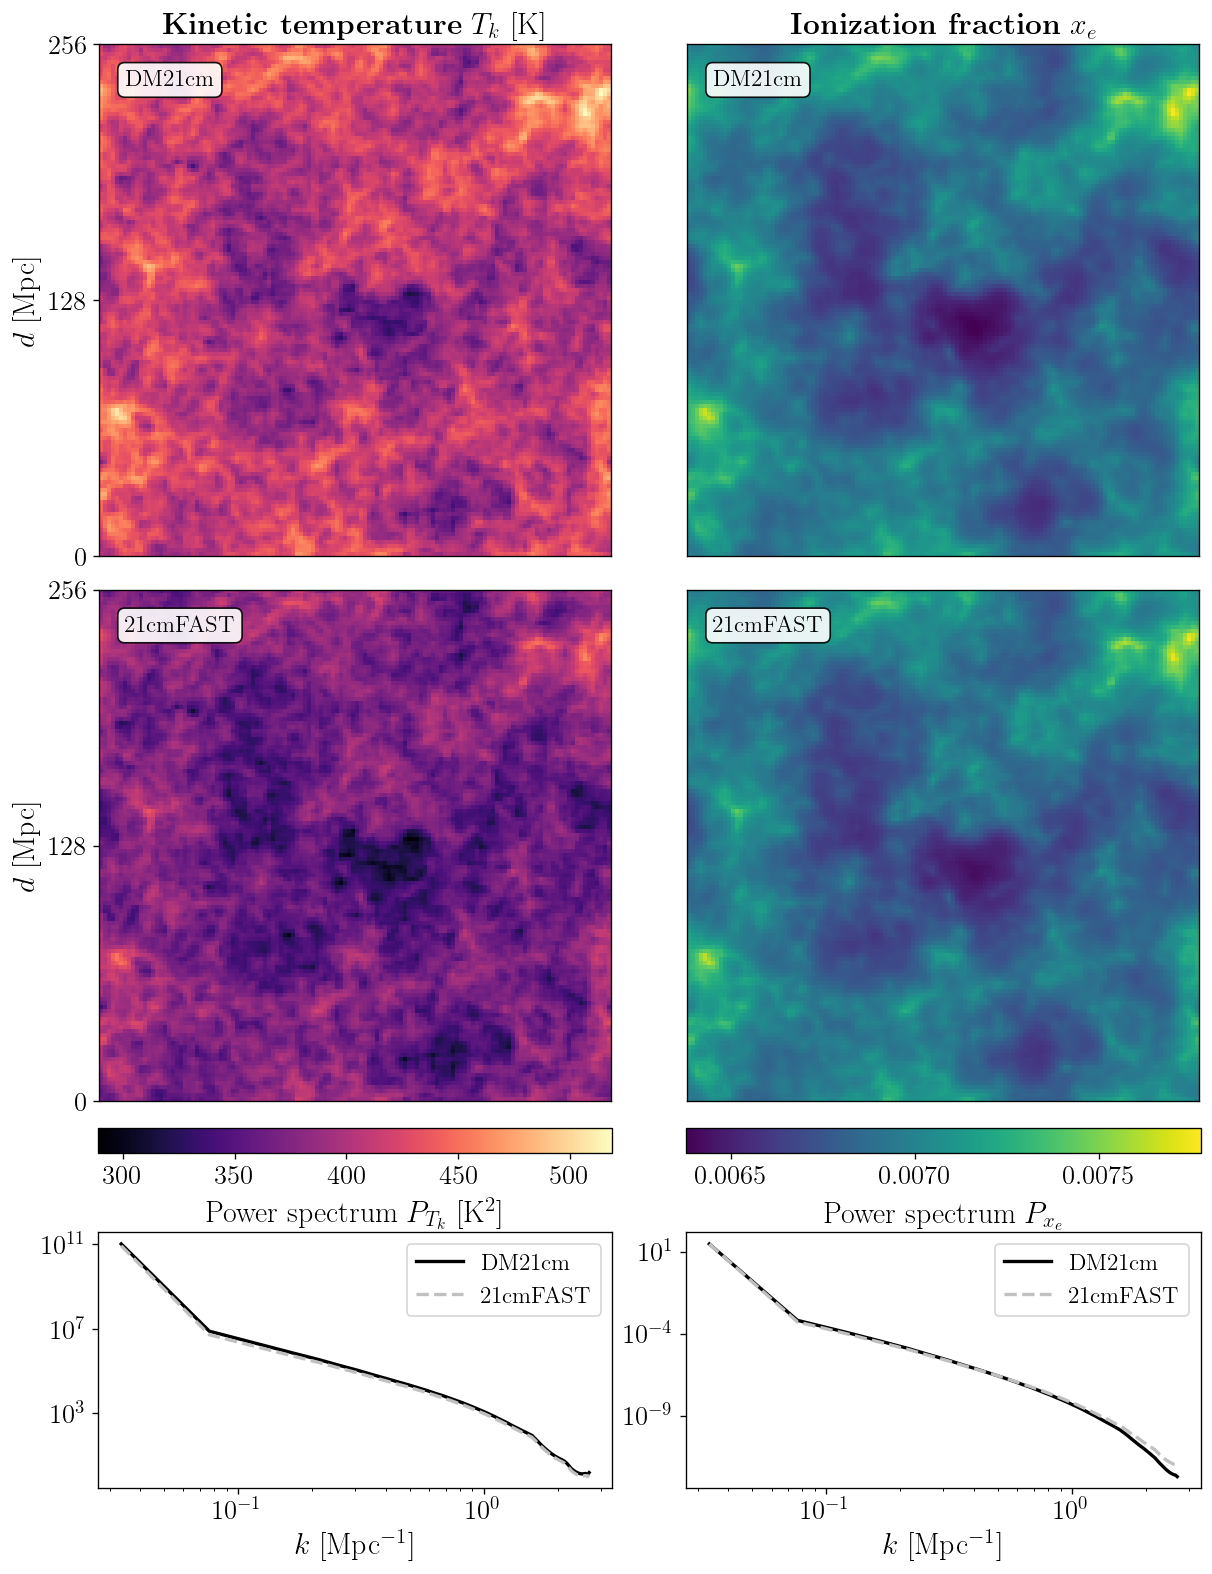

In [60]:
bbox_props = dict(boxstyle='round', facecolor='white', alpha=0.9)
text_style = dict(fontsize=14, va='top', ha='left', bbox=bbox_props)
dc_style = dict(ls='-', color='k', lw=2)
pc_style = dict(ls='--', color='silver', lw=2, zorder=10)

fig, axs = plt.subplots(3, 2, figsize=(10, 13), height_ratios=[2, 2, 1], layout='constrained')

vmin_Tk = np.min([np.min(Tk_box_dc[0]), np.min(Tk_box_pc[0])])
vmax_Tk = np.max([np.max(Tk_box_dc[0]), np.max(Tk_box_pc[0])])
vmin_xe = np.min([np.min(xe_box_dc[0]), np.min(xe_box_pc[0])])
vmax_xe = np.max([np.max(xe_box_dc[0]), np.max(xe_box_pc[0])])

ax = axs[0, 0]
ax.imshow(Tk_box_dc[0], origin='lower', extent=(0, 256, 0, 256), cmap='magma', vmin=vmin_Tk, vmax=vmax_Tk)
ax.set(title=r'\textbf{Kinetic temperature} $T_k$ [K]')
ax.set(xticks=[], yticks=[0, 128, 256], yticklabels=['0', '128', '256'], ylabel='$d$ [Mpc]')
ax.text(0.05, 0.95, 'DM21cm', transform=ax.transAxes, **text_style)

ax = axs[1, 0]
im_Tk = ax.imshow(Tk_box_pc[0], origin='lower', extent=(0, 256, 0, 256), cmap='magma', vmin=vmin_Tk, vmax=vmax_Tk)
ax.set(xticks=[], yticks=[0, 128, 256], yticklabels=['0', '128', '256'], ylabel='$d$ [Mpc]')
ax.text(0.05, 0.95, '21cmFAST', transform=ax.transAxes, **text_style)

ax = axs[0, 1]
ax.imshow(xe_box_dc[0], origin='lower', extent=(0, 256, 0, 256), cmap='viridis', vmin=vmin_xe, vmax=vmax_xe)
ax.set(title=r'\textbf{Ionization fraction} $x_e$')
ax.set(xticks=[], yticks=[])
ax.text(0.05, 0.95, 'DM21cm', transform=ax.transAxes, **text_style)

ax = axs[1, 1]
im_xe = ax.imshow(xe_box_pc[0], origin='lower', extent=(0, 256, 0, 256), cmap='viridis', vmin=vmin_xe, vmax=vmax_xe)
ax.set(xticks=[], yticks=[])
ax.text(0.05, 0.95, '21cmFAST', transform=ax.transAxes, **text_style)

ax = axs[2, 0]
ax.plot(k_bins, Tk_p_k_dc, label='DM21cm', **dc_style)
ax.plot(k_bins, Tk_p_k_pc, label='21cmFAST', **pc_style)
ax.set(xlabel='$k$ [Mpc$^{-1}$]', title='Power spectrum $P_{T_k}$ [K$^2$]')
ax.set(xscale='log', yscale='log')
ax.legend(fontsize=14)

ax = axs[2, 1]
ax.plot(k_bins, xe_p_k_dc, label='DM21cm', **dc_style)
ax.plot(k_bins, xe_p_k_pc, label='21cmFAST', **pc_style)
ax.set(xlabel='$k$ [Mpc$^{-1}$]', title='Power spectrum $P_{x_e}$')
ax.set(xscale='log', yscale='log')
ax.legend(fontsize=14)

fig.subplots_adjust(wspace=0.17, hspace=0.05)

#cax_Tk = fig.add_axes([0.1, 0.2, 0.4, 0.2])
#cax_xe = fig.add_axes([0.6, 0.2, 0.9, 0.2])
#fig.colorbar(im_Tk, cax=cax_Tk, orientation='horizontal', label='[K]', aspect=40, spacing='proportional', shrink=0.8)
#fig.colorbar(im_xe, cax=cax_xe, orientation='horizontal', label='[unitless]', aspect=40)
fig.colorbar(im_Tk, ax=axs[:2,0], orientation='horizontal', aspect=20, spacing='proportional', shrink=1., pad=0.01)
cbar = fig.colorbar(im_xe, ax=axs[:2,1], orientation='horizontal', aspect=20, spacing='proportional', shrink=1., pad=0.01)
cbar.ax.set_xticks([0.0065, 0.007, 0.0075])

fig.savefig('xraycheck.pdf', bbox_inches='tight')

## 2. Field only

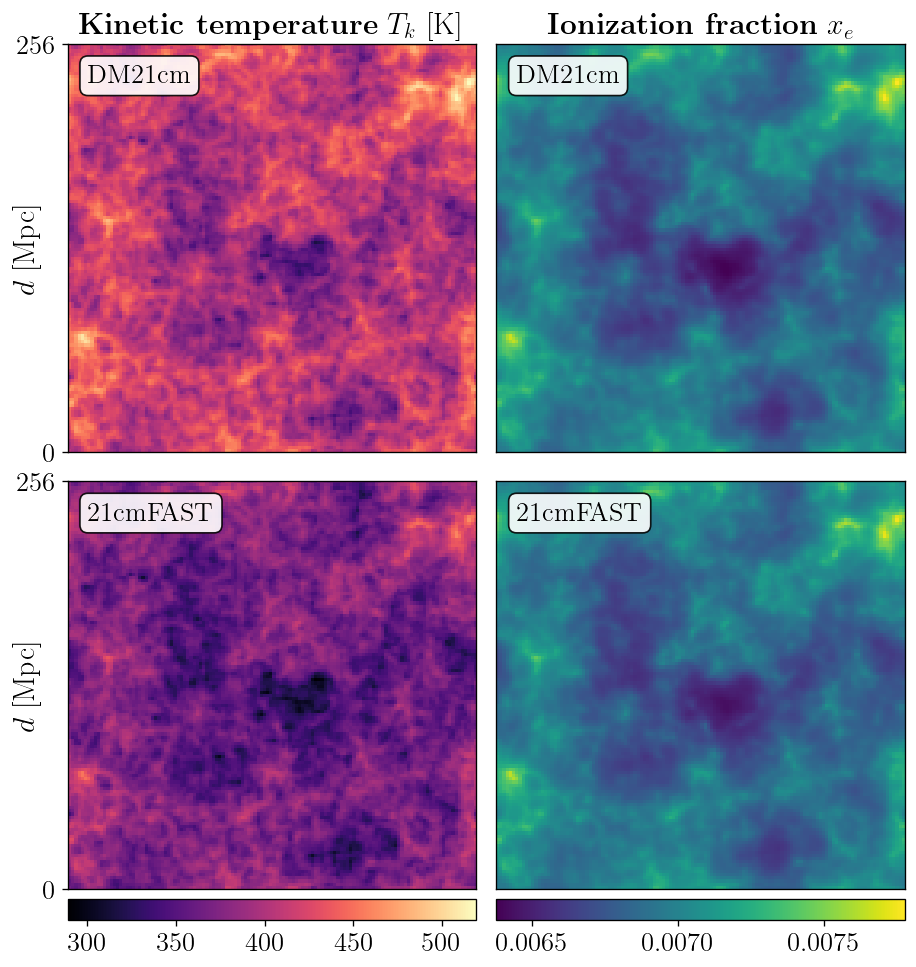

In [17]:
bbox_props = dict(boxstyle='round', facecolor='white', alpha=0.9)
text_style = dict(fontsize=16, va='top', ha='left', bbox=bbox_props)
dc_style = dict(ls='-', color='k', lw=2)
pc_style = dict(ls='--', color='silver', lw=2, zorder=10)

fig, axs = plt.subplots(2, 2, figsize=(9, 11))

vmin_Tk = np.min([np.min(Tk_box_dc[0]), np.min(Tk_box_pc[0])])
vmax_Tk = np.max([np.max(Tk_box_dc[0]), np.max(Tk_box_pc[0])])
vmin_xe = np.min([np.min(xe_box_dc[0]), np.min(xe_box_pc[0])])
vmax_xe = np.max([np.max(xe_box_dc[0]), np.max(xe_box_pc[0])])

ax = axs[0, 0]
ax.imshow(Tk_box_dc[0], origin='lower', extent=(0, 256, 0, 256), cmap='magma', vmin=vmin_Tk, vmax=vmax_Tk)
ax.set(title=r'\textbf{Kinetic temperature} $T_k$ [K]')
ax.set(xticks=[], yticks=[0, 256], yticklabels=['0', '256'])
ax.set_ylabel('$d$ [Mpc]', labelpad=-15)
ax.text(0.05, 0.95, 'DM21cm', transform=ax.transAxes, **text_style)

ax = axs[1, 0]
im_Tk = ax.imshow(Tk_box_pc[0], origin='lower', extent=(0, 256, 0, 256), cmap='magma', vmin=vmin_Tk, vmax=vmax_Tk)
ax.set(xticks=[], yticks=[0, 256], yticklabels=['0', '256'])
ax.set_ylabel('$d$ [Mpc]', labelpad=-15)
ax.text(0.05, 0.95, '21cmFAST', transform=ax.transAxes, **text_style)

ax = axs[0, 1]
ax.imshow(xe_box_dc[0], origin='lower', extent=(0, 256, 0, 256), cmap='viridis', vmin=vmin_xe, vmax=vmax_xe)
ax.set(title=r'\textbf{Ionization fraction} $x_e$')
ax.set(xticks=[], yticks=[])
ax.text(0.05, 0.95, 'DM21cm', transform=ax.transAxes, **text_style)

ax = axs[1, 1]
im_xe = ax.imshow(xe_box_pc[0], origin='lower', extent=(0, 256, 0, 256), cmap='viridis', vmin=vmin_xe, vmax=vmax_xe)
ax.set(xticks=[], yticks=[])
ax.text(0.05, 0.95, '21cmFAST', transform=ax.transAxes, **text_style)

fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.colorbar(im_Tk, ax=axs[:,0], orientation='horizontal', aspect=20, spacing='proportional', shrink=1., pad=0.01)
cbar = fig.colorbar(im_xe, ax=axs[:,1], orientation='horizontal', aspect=20, spacing='proportional', shrink=1., pad=0.01)
cbar.ax.set_xticks([0.0065, 0.007, 0.0075])

fig.savefig('xraycheck-field.pdf')

## 3. PS only

In [27]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = pbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

def ps(box, box_len, n_psbins=50, logk=True):
    power, k = compute_power(box, (box_len, box_len, box_len), n_psbins, log_bins=logk, ignore_kperp_zero=False)
    return k, power * k ** 3 / (2 * np.pi ** 2)

In [35]:
k, Tk_d_dc = ps(Tk_box_dc, 256, n_psbins=30)
k, Tk_d_pc = ps(Tk_box_pc, 256, n_psbins=30)
k, xe_d_dc = ps(xe_box_dc, 256, n_psbins=30)
k, xe_d_pc = ps(xe_box_pc, 256, n_psbins=30)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in divide
  np.bincount(


/tmp/ipykernel_398130/2167130035.py:19: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.17, hspace=0.05)


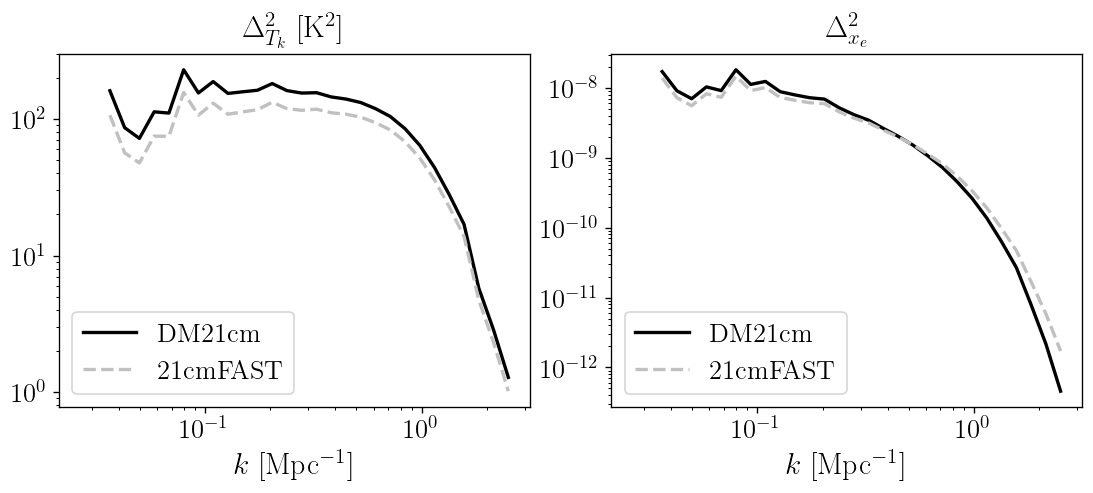

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), layout='constrained')

ax = axs[0]
ax.plot(k, Tk_d_dc, label='DM21cm', **dc_style)
ax.plot(k, Tk_d_pc, label='21cmFAST', **pc_style)
ax.set_title(r'$\Delta^2_{T_k}$ [K$^2$]', pad=11)
ax.set_xlabel('$k$ [Mpc$^{-1}$]')
ax.set(xscale='log', yscale='log')
ax.legend(fontsize=16, loc='lower left')

ax = axs[1]
ax.plot(k, xe_d_dc, label='DM21cm', **dc_style)
ax.plot(k, xe_d_pc, label='21cmFAST', **pc_style)
ax.set_title(r'$\Delta^2_{x_e}$', pad=11)
ax.set_xlabel('$k$ [Mpc$^{-1}$]')
ax.set(xscale='log', yscale='log')
ax.legend(fontsize=16, loc='lower left')

fig.subplots_adjust(wspace=0.17, hspace=0.05)
fig.savefig('xraycheck-ps.pdf', bbox_inches='tight')

/tmp/ipykernel_398130/2313194146.py:29: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.17, hspace=0.05)


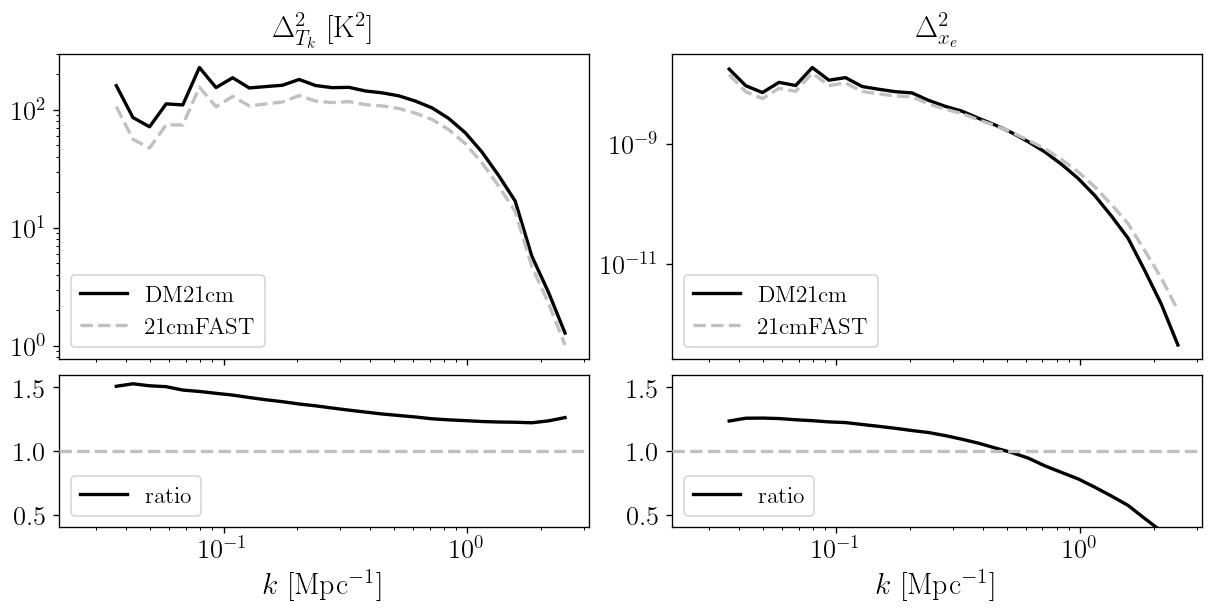

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), height_ratios=[2, 1], layout='constrained', sharex='col')

ax = axs[0, 0]
ax.plot(k, Tk_d_dc, label='DM21cm', **dc_style)
ax.plot(k, Tk_d_pc, label='21cmFAST', **pc_style)
ax.set_title(r'$\Delta^2_{T_k}$ [K$^2$]', pad=11)
ax.set(xscale='log', yscale='log')
ax.legend(fontsize=14, loc='lower left')

ax = axs[0, 1]
ax.plot(k, xe_d_dc, label='DM21cm', **dc_style)
ax.plot(k, xe_d_pc, label='21cmFAST', **pc_style)
ax.set_title(r'$\Delta^2_{x_e}$', pad=11)
ax.set(xscale='log', yscale='log')
ax.legend(fontsize=14, loc='lower left')

ax = axs[1, 0]
ax.plot(k, Tk_d_dc / Tk_d_pc, label='ratio', **dc_style)
ax.axhline(1, **pc_style)
ax.set(xlabel='$k$ [Mpc$^{-1}$]', ylim=(0.4, 1.6))
ax.legend(fontsize=14, loc='lower left')

ax = axs[1, 1]
ax.plot(k, xe_d_dc / xe_d_pc, label='ratio', **dc_style)
ax.axhline(1, **pc_style)
ax.set(xlabel='$k$ [Mpc$^{-1}$]', ylim=(0.4, 1.6))
ax.legend(fontsize=14, loc='lower left')

fig.subplots_adjust(wspace=0.17, hspace=0.05)

In [57]:
z = np.nan_to_num(xe_d_dc / xe_d_pc, nan=1)
np.max(np.sqrt(z))

1.1219119381173606

In [58]:
z = np.nan_to_num(Tk_d_dc / Tk_d_pc, nan=1)
np.max(np.sqrt(z))

1.236256581205007

## 3. Power spectrum

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
vmin = 0
vmax = 0.00775
im = axs[0].imshow(xe_box_pc[0], origin='lower', extent=(0, 256, 0, 256), vmin=vmin, vmax=vmax, cmap='binary')
axs[1].imshow(xe_box_pc[0] - xe_box_dc[0], origin='lower', extent=(0, 256, 0, 256), vmin=vmin, vmax=vmax, cmap='binary')

fig.colorbar(im, ax=axs)

In [ ]:
plt.imshow(xe_box_pc[0] - xe_box_dc[0], origin='lower', extent=(0, 256, 0, 256))
plt.colorbar()

In [20]:
p_k_pc, k_bins = pbox.get_power(xe_box_pc, 256)
p_k_dc, k_bins = pbox.get_power(xe_box_dc, 256)

In [ ]:
p_k_pc - p_k_dc

In [ ]:
plt.plot(k_bins, p_k_pc)
plt.plot(k_bins, p_k_dc, ':')
plt.loglog()

In [ ]:
z = np.array([-0.02454369260617026, 0.0, 0.02454369260617026]) * 1j
z.dtype

In [ ]:
BOX_LEN = 256
n_psbins = 50

power, k = compute_power(
    Tk_box_pc,
    (BOX_LEN, BOX_LEN, BOX_LEN+0.001),
    n_psbins,
    log_bins=True,
)

In [ ]:
np.exp(1j)